### Install the model:
`! pip install ollama llama-index-llms-ollama`
`! sudo snap install ollama`
`! ollama pull llama3`

### After downloading the base model and creating the modelfile, we create the parametrised model for our task:
`! ollama create [model name] -f [modelfile name]`

In [1]:
from llama_index.llms.ollama import Ollama
from lib.dataset_utils import load_twitter_data_cleaned, load_goemotions_cleaned
from lib.plot_utils import *
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd


### Loading Twitter

In [2]:
_, _, twitter_test = load_twitter_data_cleaned() 
twitter_emotions = ('joy', 'sadness','anger', 'fear', 'love', 'surprise')

### Loading Goemotions

In [3]:
import json
label_mapping_path = "./dataset/GoEmotionsSplit/label_mapping.json"
_, _, goemotions_test = load_goemotions_cleaned()
json1_file = open(label_mapping_path)
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
goemotions_emotions = str(json1_data.values())

In [4]:

SAMPLES = """ 
text: 1. i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
2. im updating my blog because i feel shitty

answer:{
    "1": "joy"
    "2": "sadness"
    }
"""
SINGLE_BASE_PROMPT = """<|start_header_id|>system<|end_header_id|> Classify the sentences. Choose ONLY ONE EMOTION among the following: """ 

MULTI_BASE_PROMPT = """<|start_header_id|>system<|end_header_id|> Classify the sentences. Choose a maximum of three emotions among the following: """ 

SAMPLES_STRING = """Here are some samples:"""

TERMINATOR_STRING = """<|eot_id|>"""

In [5]:
class Llama3():
    def __init__(self, name, timeout = 1000.0, scores={}):
        self.model = Ollama(model=name, request_timeout=timeout)
        self.scores = scores

    def predict(self, emotions, test, samples = None, batch_dim = 8, single_label = True, progress_bar = False):
        # emotions : emotions to classify
        # test : test data to classify
        # samples : samples to show in prompt (to be taken from training data?), for now are hardcoded
        test_loader = DataLoader(test, batch_size = batch_dim, shuffle = False)
        predictions = []
        base_prompt = self.generate_base_prompt(emotions, samples, single_label) # to avoid recreating the prompt from scratch at every batch
        for data in tqdm(test_loader, disable=not progress_bar):
            batch_prompt = self.add_test_data_to_prompt(base_prompt, data[0])
            predictions.append(self.classify_batch(batch_prompt, emotions))
        predictions = flatten(predictions)
        if len(predictions) == len(test):
            results = self.evaluate(test.targets, predictions, self.scores, emotions)
            print(results)
        else:
            print(f"Error: predictions and test data do not match: pred: {len(predictions)} vs test:{len(test)}")

    def generate_base_prompt(self, emotions, samples, single_label = True):
        prompt = ""
        if single_label:
            prompt = SINGLE_BASE_PROMPT + str(emotions) 
        else:
            prompt = MULTI_BASE_PROMPT + str(emotions) 
        if samples:
            prompt += SAMPLES_STRING + samples 
        return prompt + TERMINATOR_STRING
                
    def add_test_data_to_prompt(self, prompt, test):
        # appends data to classify to base prompt
        for index, row in enumerate(test):
            prompt += (str(index) + '. ' + row + '\n')
        prompt += TERMINATOR_STRING
        return prompt

    def classify_batch(self, prompt, emotions):
        # classify batch of data
        # response is formatted as JSON
        response = self.model.complete(prompt).text
        predictions = self.extract_emotions(response, emotions)
        return list(predictions.values())
    
    def evaluate(self, targets, predictions, scores, emotions, single_label = True):
        # evaluate the model
        if single_label:
            lb = LabelBinarizer()
        else:
            lb = MultiLabelBinarizer()
        bin_predictions = lb.fit_transform(predictions)
        bin_predictions = pd.DataFrame(bin_predictions, columns = lb.classes_) 
        if 'other' in bin_predictions.columns:
            bin_predictions.drop(columns=['other'], inplace=True) # 'other' if emotion not in the allowed ones
        scores = {name: score(targets, bin_predictions) for name, score in scores.items()}
        plot_score_barplot(targets, bin_predictions, emotions)
        print(classification_report(targets, bin_predictions, target_names=emotions))
        if not single_label:
            plot_multilabel_confusion_heatmap(targets, bin_predictions, emotions)
        return scores

    def extract_emotions(self, answers, emotions):
        # extracts emotions from JSON response 
        answers[answers.find('{'):] # skips optional text before JSON
        answers = json.loads(answers)
        for key, value in answers.items():
            if value not in emotions:
                answers.update({key : 'other'})
        return answers

def accuracy(targets, predictions):
    return accuracy_score(targets, predictions)
def jaccard(targets, predictions):
    return jaccard_score(targets, predictions, average='micro', zero_division=0)
def jaccard_samples(targets, predictions):
    return jaccard_score(targets, predictions, average='samples', zero_division=0)
def f1(targets, predictions):
    return f1_score(targets, predictions, average='macro', zero_division=0)
def f1_micro(targets, predictions):
    return f1_score(targets, predictions, average='micro', zero_division=0)


def flatten(xss):
    # flattens list of lists into a single list
    return [x for xs in xss for x in xs]

class Llama_EmotionsData(Dataset):
    def __init__(self, dataframe) -> None:
        self.text = dataframe['text']
        self.targets = dataframe.drop(columns=['text']).to_numpy()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        return self.text[index], self.targets[index]




100%|██████████| 8/8 [04:15<00:00, 31.94s/it]
/home/nsiva/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nsiva/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         joy       0.57      0.40      0.47        10
     sadness       0.40      0.44      0.42         9
       anger       0.82      0.43      0.56        21
        fear       0.07      1.00      0.13         1
        love       0.67      0.35      0.46        23
    surprise       0.00      0.00      0.00         0

   micro avg       0.43      0.41      0.42        64
   macro avg       0.42      0.44      0.34        64
weighted avg       0.65      0.41      0.48        64
 samples avg       0.41      0.41      0.41        64

{'accuracy': 0.40625, 'jaccard': 0.26262626262626265, 'jaccard_samples': 0.40625, 'f1': 0.3407695095582093, 'f1_micro': 0.4159999999999999}


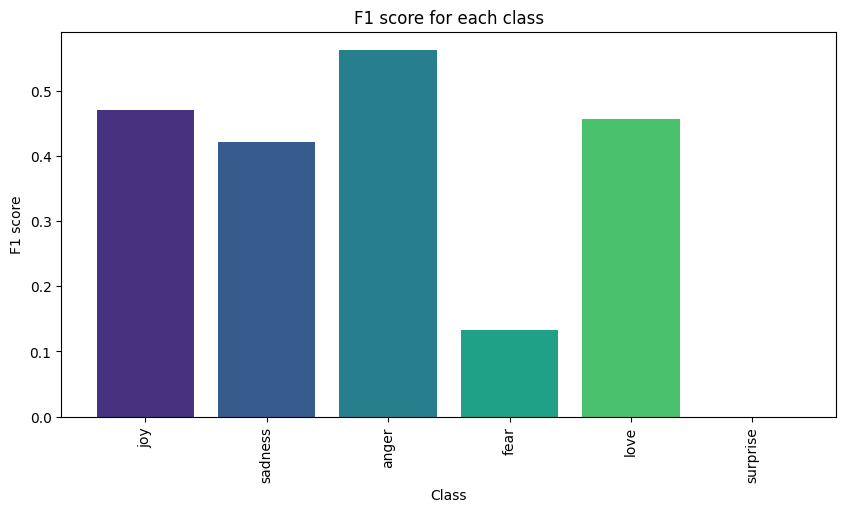

In [6]:
llama3 = Llama3("ParametrisedLlama3", scores = {"accuracy": accuracy, "jaccard": jaccard, 
                                                "jaccard_samples":jaccard_samples, "f1": f1, "f1_micro": f1_micro})
twitter_test_dataset = Llama_EmotionsData(twitter_test[:64])
llama3.predict(twitter_emotions, twitter_test_dataset, samples = SAMPLES, single_label = True, progress_bar = True)

